In [28]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [29]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin,total_good_number):
    
    fraction = []
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog)
    good_fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        good_fraction.append(len(good_catalog)*1.0/total_good_number)
    return log_deltach2_bin['bin'][0:-1],fraction,good_fraction

In [30]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [31]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [32]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [33]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift success rate:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)
    #print('Bad_1 to total Bad fraction:'. len(bad_1)/len())

In [34]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    total_good = len(x_good)
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [35]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [141]:
#dataname = 'ELG_80606_Cascades_subsamples.fits'
dataname ='LRG_80605_80609.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)
#search = np.where((SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']>1.4) &  (SV_depth_catalog['best_quality']>=2.5))
#SV_depth_catalog['Z'][search[0]]=SV_depth_catalog['best_z'][search[0]]
#SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['subset_id']==2]
SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>20')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>30')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.4)]
print('DELTACHI2_cas>20 & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>30) & (SV_depth_catalog['Z']<1.4)]
print('DELTACHI2_cas>30 & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift success rate: 0.94383600112328
Good data completeness: 1.0
Combined value: 0.94383600112328
--------
DELTACHI2_cas>20
Redshift success rate: 0.9704462326261888
Good data completeness: 0.9867598928890211
Combined value: 0.9575974205607721
--------
DELTACHI2_cas>30
Redshift success rate: 0.9759750852736171
Good data completeness: 0.979024099970247
Combined value: 0.955503129453388
--------
DELTACHI2_cas>20 & Redrock_z<1.4
Redshift success rate: 0.9804560260586319
Good data completeness: 0.9851234751562035
Combined value: 0.9658702476287206
--------
DELTACHI2_cas>30 & Redrock_z<1.4
Redshift success rate: 0.9841222288795686
Good data completeness: 0.9773876822374293
Combined value: 0.9618689443229345


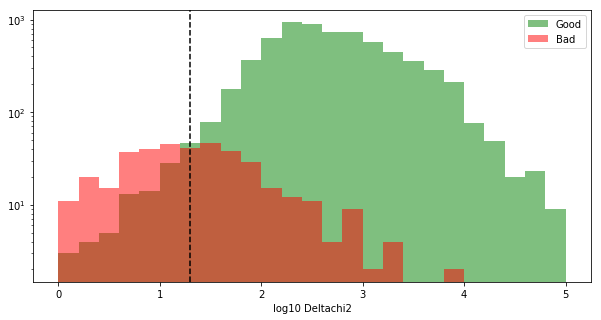

In [119]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
plt.figure(figsize=(10,5))
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')

plt.axvline(np.log10(20),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

Text(0, 0.5, 'log10 DELTACHI2')

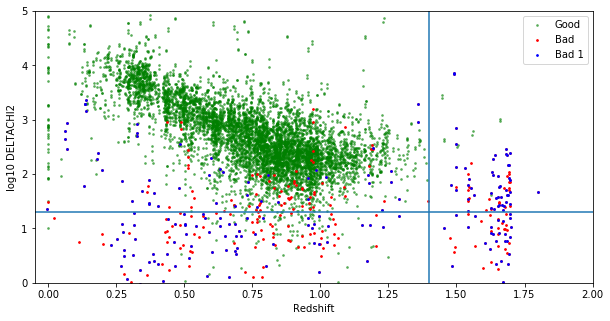

In [120]:
plt.figure(figsize=(10,5))
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')


plt.legend()
plt.xlim(-0.05,2)
plt.ylim(0,5)

plt.axvline(1.4)
plt.axhline(np.log10(20))
plt.xlabel('Redshift')
plt.ylabel('log10 DELTACHI2')

Text(0, 0.5, 'log10 DELTACHI2')

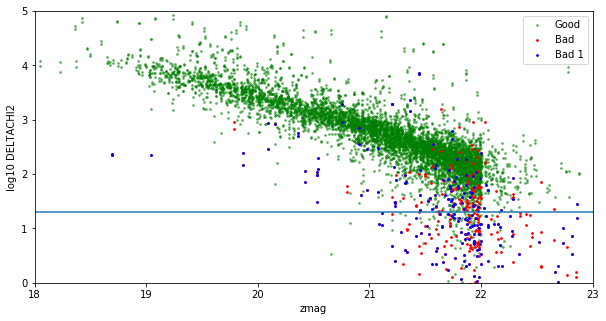

In [121]:
plt.figure(figsize=(10,5))
plt.scatter(flux_to_mag(good_catalog)['z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=3,alpha=0.5,label='Good')
plt.scatter(flux_to_mag(bad_catalog)['z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
plt.scatter(flux_to_mag(bad_1)['z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')


plt.legend()
plt.xlim(18,23)
plt.ylim(0,5)

plt.axvline(1.4)
plt.axhline(np.log10(20))
plt.xlabel('zmag')
plt.ylabel('log10 DELTACHI2')

Text(0.5, 1.0, 'LRG 80605 & 80609')

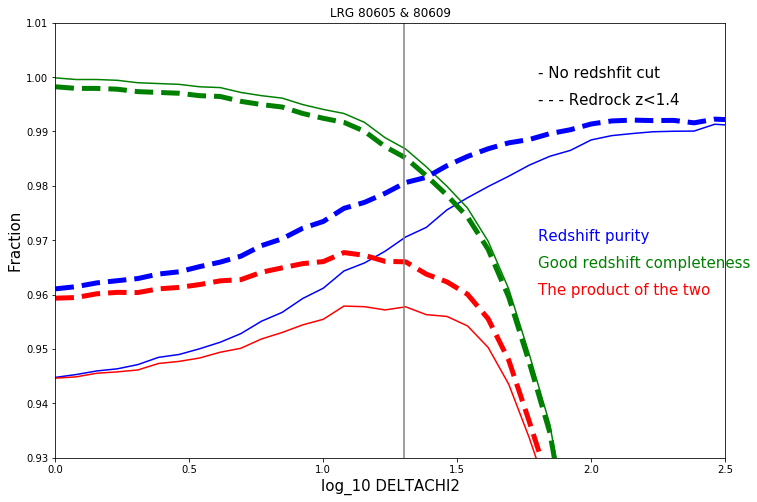

In [125]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)

log_deltach2_bin = my_wise_ut.my_bin_maker(0.0,3,40)
plt.figure(figsize=(12,8))
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.subplot(1,1,1)
plt.plot(bins,fraction,color='b')
plt.plot(bins,good_fraction,color='g')
plt.plot(bins,np.array(good_fraction)*fraction,color='r')
plt.ylim(0.93,1.01)
plt.xlim(0.0,2.5)
#plt.axhline(0.98,ls='--')

SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['Z']<1.4]
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.plot(bins,fraction,color='b',ls='--',lw=5)
plt.plot(bins,good_fraction,color='g',ls='--',lw=5)
plt.plot(bins,np.array(good_fraction)*fraction,color='r',ls='--',lw=5)

plt.text(1.8,1.0,'- No redshfit cut',fontsize=15,color='black')
plt.text(1.8,0.995,'- - - Redrock z<1.4',fontsize=15,color='black')
plt.text(1.8,0.97,'Redshift purity',fontsize=15,color='b')
plt.text(1.8,0.965,'Good redshift completeness',fontsize=15,color='g')
plt.text(1.8,0.96,'The product of the two',fontsize=15,color='r')
plt.xlabel('log_10 DELTACHI2',fontsize=15)
plt.axvline(np.log10(20),color='grey')
plt.ylabel('Fraction',fontsize=15)
plt.title('LRG 80605 & 80609')

Text(0, 0.5, 'DELTACHI2_3x4_cascades')

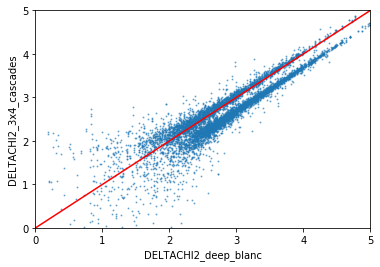

In [126]:
#SV_depth_catalog = pf.getdata(dir+dataname,1)
#SV_depth_catalog = SV_depth_catalog[SV_depth_catalog['TILEID']==80609]
plt.scatter(np.log10(SV_depth_catalog['DELTACHI2']),np.log10(SV_depth_catalog['DELTACHI2_cas']),s=1,alpha=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot(np.arange(0,10),np.arange(0,10),color='r')
plt.xlabel('DELTACHI2_deep_blanc')
plt.ylabel('DELTACHI2_3x4_cascades')

In [147]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog
total = (len(SV_depth_catalog))
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['DELTACHI2_cas']<60) & (SV_depth_catalog['Z']<1.4)])/total)

0.04507160909856782


In [148]:
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['DELTACHI2_cas']<40) & (SV_depth_catalog['Z']<1.4)])/total)

0.020780679584386407


In [150]:
print(len(SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>60) & (SV_depth_catalog['DELTACHI2_cas']<80) & (SV_depth_catalog['Z']<1.4)])/total)

0.02597584948048301
